In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm

import zarr
import xarray as xr
import os
from sklearn import preprocessing
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.nn import Linear, Conv1d, ConvTranspose1d

from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.functional import F
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm

from tqdm.notebook import tqdm
import json

In [2]:
from models import DriverDatasets, MicroAutoEncoder, CNNEncoderVAE, CNNDecoder

## Load the Datasets

In [3]:
trainloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/trainloader_twocat.pth')
valloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/valloader_twocat.pth')
testloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/testloader_twocat.pth')

In [4]:
class DecoderBinFromMoments(torch.nn.Module):
    def __init__(self,n_bins=35,n_moms=4,n_hidden=50):
        super(DecoderBinFromMoments, self).__init__()
 
        self.decoder = CNNDecoder(n_bins=n_bins,n_latent=n_moms)
    
    def forward(self,momt0):
        
        bs = momt0.shape[0]

        Rt0 = self.decoder(momt0[:,0:2,:].flatten(start_dim=1))
        
        return Rt0

In [5]:
def recon_loss(recon_x,x):
    mseloss = torch.nn.MSELoss()
    mse = mseloss(recon_x,x)

    return mse
def vae_loss(recon_x,x,mu,logvar):
    mseloss = torch.nn.MSELoss()

    reconloss = mseloss(recon_x,x)
    
    kldweight = 1e-6
    kldloss = torch.mean(-0.5*torch.sum(1+logvar-mu**2-logvar.exp(),dim=1),dim=0)
    
    loss = reconloss+kldweight*kldloss
    
    return loss

In [6]:
a0 = 1 #e-3
b = 0

def train(model,dataloader,criterion,device,epoch):
    model.train()
    
    for data in dataloader:
        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        bin1 = bin1coal #bin1condevap #

        M = M.to(device)
        bin0 = bin0.to(device)
        binmag = binmag.to(device)
        bs = bin1.size(0)
        #with torch.autograd.set_detect_anomaly(True):
        optimizer.zero_grad()

        normRt0 = model(torch.Tensor(M).float())

        normbin0 = bin0.float()*torch.broadcast_to(binmag[:,0:2].float().unsqueeze(dim=2),(bs,2,35))
            
            
        Rloss0 = recon_loss(normRt0,bin0.float()) #+recon_loss(binmagRt0,binmag[:,0:2].float())

        loss = Rloss0

        loss.backward()
        
        optimizer.step()
        
        
    return model
def test(model,dataloader,criterion,device,val=False):
    model.eval()
    correct = 0
    R0all = 0
    R1all = 0
    Lall = 0
    losstot = 0
    recon = 0

    with torch.no_grad():
        for data in dataloader:
            M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
             
            M = M.to(device)
            bin0 = bin0.to(device)
            binmag = binmag.to(device)
            bs = bin0.size(0)
            #with torch.autograd.set_detect_anomaly(True):
            optimizer.zero_grad()

            normRt0 = model(torch.Tensor(M).float())

            normbin0 = bin0.float()*torch.broadcast_to(binmag[:,0:2].float().unsqueeze(dim=2),(bs,2,35))
            
            Rloss0 = recon_loss(normRt0,bin0.float()) #+recon_loss(binmagRt0,binmag[:,0:2].float())

            lossall = Rloss0
            
            nn = len(dataloader.dataset)

            losstot = losstot+lossall
            
        if val==True:
            sched.step(losstot/nn)

        return losstot/nn

def inference(model,dataloader,device,nlatent,singlecat=True):
    model.eval()
    dataset = dataloader.dataset

    ntargets = nlatent+2
    nmoms = 4
    nrates = 3
    bs = 500
    print(len(dataset))
    
    pred = np.zeros((len(dataset),ntargets,nrates))
    real = np.zeros((len(dataset),ntargets,nrates))
    
    #[500, 3, 3, 2]) torch.Size([500, 3, 3, 2] 
    if singlecat:
        realM = np.zeros((len(dataset),nmoms,nrates))
        realdMdt = np.zeros((len(dataset),nmoms,nrates))
    else:
        realM = np.zeros((len(dataset),3,3,2))
        realdMdt = np.zeros((len(dataset),3,3,2))    
    

    realbin0 = np.zeros((len(dataset),2,35))
    predbin0 = np.zeros((len(dataset),2,35))

    jj = 0
    i = 0

    for data in dataloader:
        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        M = M.to(device)
        normRt0 = model(torch.Tensor(M).float())        
        
        bs = normRt0.size(0)
        normbin0 = bin0.float()*torch.broadcast_to(binmag[:,0:2].float().unsqueeze(dim=2),(bs,2,35))
        
        if normRt0 is not(None):
            if singlecat:
                realM[jj:jj+bs,:,:] = M1.cpu().detach().numpy().reshape(bs,nmoms,nrates)
                realdMdt[jj:jj+bs,:,:] = dM1dt.cpu().detach().numpy().reshape(bs,nmoms,nrates)
            else:
                realM[jj:jj+bs,:,:] = M2.cpu().detach().numpy().reshape(bs,3,3,2)
                realdMdt[jj:jj+bs,:,:] = dM2dt.cpu().detach().numpy().reshape(bs,3,3,2)

            realbin0[jj:jj+bs,:] = normbin0.cpu().detach().numpy().reshape(bs,2,35)
            predbin0[jj:jj+bs,:] = normRt0.cpu().detach().numpy().reshape(bs,2,35)

            
            jj=jj+bs
            i = i+1
        else:
            break

    return realM,realdMdt,realbin0,predbin0

In [17]:
n_rep = 10

for j in range(0,n_rep):
    print("Training model n = ",str(j))
    init_lr = 1e-3
    weight_decay = 1e-3
    total_epochs = 1000

    # Learning rate strings so its in the correct format for the filenames
    lrval='{:3.0e}'.format(init_lr)[0]
    lrexp = '{:3.0e}'.format(init_lr)[4]

    model = DecoderBinFromMoments(n_bins=35,n_moms=4)


    # Check if there is a gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print(device)
    #print(model)
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr, weight_decay=weight_decay)

    sched =  ReduceLROnPlateau(optimizer, 'min')
    criterion = torch.nn.MSELoss()
    
    val_loss_all = []
    train_loss_all = []
    
    e0 = 0
    epochs = 500
    best_epoch = 0
    
    min_loss = 1e10

    for epoch in tqdm(range(e0,epochs)):
        mod = train(model,trainloader,criterion,device,epoch)
        train_loss = test(model,trainloader,criterion,device)
        val_loss = test(model,valloader,criterion,device,val=True)

        train_loss_all.append(train_loss.cpu())
        val_loss_all.append(val_loss.cpu())

        if epoch%50==0:
            print(f'{epoch:03d}, Train: {train_loss:.8e}, Val.: {val_loss:.8e}')
            
        if val_loss<min_loss:
            bestmodel = model
            min_loss = val_loss
            best_epoch = epoch
    
    tmp_trainloss = "MomentDistsModels/TwoCatMomentDecoder_CNN_n{}_mse_{}epochs_losses_sc.npz".format(j,epochs)
    tmp_valloss = "MomentDistsModels/TwoCatMomentDecoder_CNN_n{}_mse_{}epochs_valloss_sc.npz".format(j,epochs)
    mod_weights = "MomentDistsModels/TwoCatMomentDecoder_CNN_n{}_mse_{}epochs_sc".format(j,epochs)
    
    print(tmp_trainloss)
    print(tmp_valloss)
    print(mod_weights)
    print(best_epoch)
    
    torch.save(bestmodel.state_dict(),mod_weights)
    
    train_loss_np = np.array(train_loss_all)
    val_loss_np = np.array(val_loss_all)

    np.savez(tmp_trainloss,trainl=train_loss_np,vall=val_loss_np)
            
    #name = "modelweights/MomentDecoder_CNN_1000epochs_Sigmoid_magnitude_TwoCatTwoMomnorm_PlateauSched"+
    #torch.save(model.state_dict(),"modelweights/MomentDecoder_CNN_1000epochs_Sigmoid_magnitude_TwoCatTwoMomnorm_PlateauSched")

Training model n =  0
Training model n =  1
Training model n =  2
Training model n =  3
Training model n =  4
Training model n =  5
Training model n =  6
Training model n =  7
Training model n =  8
Training model n =  9


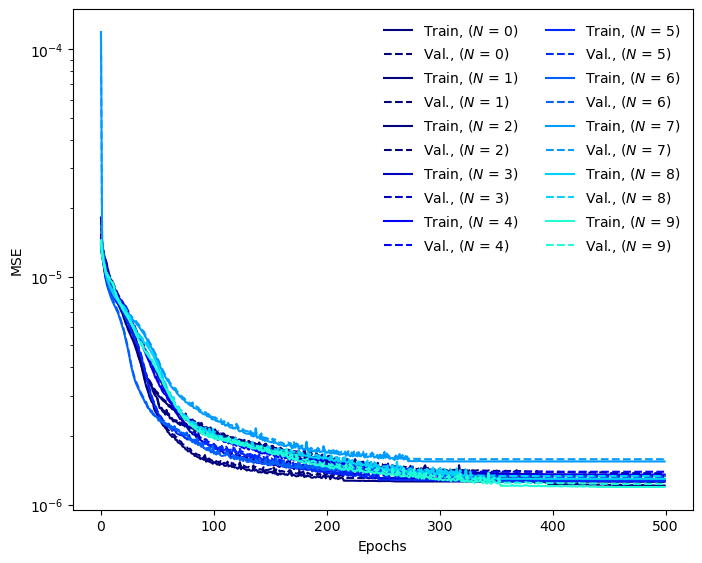

<Figure size 640x480 with 0 Axes>

In [7]:
trainloss = []
valloss = []

n_rep=10
fig = plt.figure(figsize=(8,6.5))
norm = matplotlib.colors.Normalize(vmin=2.0, vmax=20.0)
cols = cm.jet(norm(np.arange(0,n_rep)),bytes=True)/256


for j in range(0,n_rep):
    epochs = 500
    fnloss = 'MomentDistsModels/TwoCatMomentDecoder_CNN_n{}_mse_{}epochs_losses_sc.npz'.format(j,epochs)
    
    loss = np.load(fnloss)
    trainloss.append(loss['trainl'])
    valloss.append(loss['vall'])
    
    plt.plot(trainloss[j],label=r"Train, ($N$ = "+str(j)+")",c = tuple(cols[j]))
    plt.plot(valloss[j],label=r"Val., ($N$ = "+str(j)+")", linestyle='dashed',c = tuple(cols[j]))

plt.legend(loc='upper right',ncol=2,frameon=False)
plt.yscale('log')
plt.ylabel("MSE")
plt.xlabel("Epochs")
plt.show()
plt.tight_layout()
#plt.savefig("MSELoss_TwoMoments_Decoder.png")

In [8]:
from scipy.stats import wasserstein_distance

In [9]:
def kl_divergence(p, q):
    q = q+1e-14
    p = p+1e-14
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))
def mse(p, q):

    return np.sum((p-q)**2)/len(p)

def wasserstein(a,b):
    a = a/(np.sum(a,keepdims=True)+1e-14)
    b = b/(np.sum(b,keepdims=True)+1e-14)
    
    cdf_a = np.cumsum(a)
    cdf_b = np.cumsum(b)

    return wasserstein_distance(cdf_a,cdf_b)

In [10]:
def calcwasserstein(bina,binb):
    bina = bina/(np.sum(bina,axis=1,keepdims=True)+1e-14)
    binb = binb/(np.sum(binb,axis=1,keepdims=True)+1e-14)
    
    cdf_a = np.cumsum(bina,axis=1)
    cdf_b = np.cumsum(binb,axis=1)
    
    dist = np.zeros(cdf_a.shape[0])
    distkl = np.zeros(cdf_a.shape[0])
    distmse = np.zeros(cdf_a.shape[0]) 
    for i in range(0,cdf_a.shape[0]):
        dist[i]=wasserstein_distance(cdf_a[i,:],cdf_b[i,:])
        distkl[i]=kl_divergence(bina[i,:],binb[i,:])
        distmse[i]=mse(bina[i,:],binb[i,:])
    return dist,distkl,distmse

In [11]:
epochs = 500

In [12]:
len(testloader.dataset)

32062

In [13]:
n_rep = 10
n_test = len(testloader.dataset)

wdistances = np.zeros((n_rep,n_test,2))
kldistances = np.zeros((n_rep,n_test,2))
msedistances = np.zeros((n_rep,n_test,2))

wdistrep = np.zeros((n_rep,2))
kldistrep = np.zeros((n_rep,2))
msedistrep = np.zeros((n_rep,2))

realizations = np.ones((n_rep,n_test))

for j in range(0,n_rep):
    print("Training model n = ",str(j))

    nlatent = 3
    sc = True
    
    model = DecoderBinFromMoments(n_bins=35,n_moms=4)

    # Check if there is a gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    mod_weights = "MomentDistsModels/TwoCatMomentDecoder_CNN_n{}_mse_{}epochs_sc".format(j,epochs)
    model.load_state_dict(torch.load(mod_weights))

    testM,testdMdt,testrealbin0,testpredbin0=inference(model,testloader,device,nlatent,singlecat=sc)

    wdistances[j,:,0],kldistances[j,:,0],msedistances[j,:,0]=calcwasserstein(testrealbin0[:,0,:],testpredbin0[:,0,:])
    wdistances[j,:,1],kldistances[j,:,1],msedistances[j,:,1]=calcwasserstein(testrealbin0[:,1,:],testpredbin0[:,1,:])
    
    
    wdistrep[j,0] = np.mean(wdistances[j,:,0])
    wdistrep[j,1] = np.std(wdistances[j,:,1])
    kldistrep[j,0] = np.mean(kldistances[j,:,0])
    kldistrep[j,1] = np.mean(kldistances[j,:,1])
    msedistrep[j,0] = np.mean(msedistances[j,:,0])
    msedistrep[j,1] = np.mean(msedistances[j,:,1])
    
    realizations[j,:]=np.ones(n_test)*j
    
    d = {r"Wasserstein Dist. ($l_{1}$)":np.log(wdistances[j,:,0]),'KL-Div.':np.log(kldistances[j,:,0]),"MSE": np.log(msedistances[j,:,0]),"Realization":realizations[j,:].astype(int)}
    df = pd.DataFrame(data=d)
    
    if j==0:
        twocatdf = df
    else:
        twocatdf = pd.concat([twocatdf,df])
    
print("MSE: ", np.mean(msedistances[j,:,0].flatten()),np.std(msedistances[j,:,0].flatten()))
print("KL: ", np.mean(kldistances[j,:,0].flatten()),np.std(kldistances[j,:,0].flatten()))
print("Wasserstein: ", np.mean(wdistances[j,:,0].flatten()),np.std(wdistances[j,:,0].flatten()))

Training model n =  0
32062
Training model n =  1
32062
Training model n =  2
32062
Training model n =  3
32062
Training model n =  4
32062
Training model n =  5
32062
Training model n =  6
32062
Training model n =  7
32062
Training model n =  8
32062
Training model n =  9
32062
MSE:  0.0006008473028249166 0.0013538037680177024
KL:  0.16477464445678944 0.26223465844080024
Wasserstein:  0.012347716405752183 0.009567038476487407


In [14]:
np.save("recmetrics/twocatwasserstein",wdistrep)
np.save("recmetrics/twocatkl",kldistrep)
np.save("recmetrics/twocatmse",msedistrep)

In [15]:
twocatdf.to_csv("recmetrics/twocatdf.csv")